In [169]:
%matplotlib notebook
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import ipywidgets as widgets
from io import BytesIO
from IPython.display import display
import pickle

image = None
fourier = None
magnitude_spectrum = None
cropped_fourier = None
phaseangle = None
unwrapped_phase = None
image_buffer = BytesIO()


# Initialize default values
rect_center_x = 200
rect_center_y = 200
rect_center_radius = 20

width = 0 #2592//2
height = 0 #1944//2

In [170]:
#image_url = 'http://192.168.2.123:8000/image.jpg?x=1024&y=1024&raw=1'
image_url = 'image_3.jpg'

In [177]:


def capture_image():
    global image, image_url, image_buffer
    if image_url.startswith("http"):
        # Get the image from the raspberry pi camera over HTTP
        with urllib.request.urlopen(image_url) as r:
            image = pickle.loads(r.read())
            print(image.shape)
    else:
        image = plt.imread(image_url)
        
    # Extract the red channel of the image
    if image.ndim == 1:
        image = image[:,:]
    elif image.ndim == 3:
        image = image[:,:,0]
    else:
        print("Invalid number of layers in image")
    global width
    width = image.shape[1]
    global height
    height = image.shape[0]
    
def calculate_fourier():
    global fourier, magnitude_spectrum
    fourier = np.fft.fftshift(np.fft.fft2(image))
    magnitude_spectrum = np.log(np.abs(fourier+1e-9))
        
def calculate_phaseangle():
    global fourier, phaseangle, cropped_fourier, rect_center_x, rect_center_y, rect_center_radius, width, height
    cropped_fourier = np.zeros([height, width], dtype=complex)
    satellite = fourier[rect_center_y - rect_center_radius:rect_center_y + rect_center_radius,
                rect_center_x - rect_center_radius:rect_center_x + rect_center_radius]
    cropped_fourier[height//2 - rect_center_radius:height//2 + rect_center_radius,
                    width//2 - rect_center_radius:width//2 + rect_center_radius] = satellite
    phaseangle = np.angle(np.fft.ifft2(np.fft.fftshift(cropped_fourier)))
def reconstruct_phase():
    global phaseangle, width, height, unwrapped_phase
    x2 = np.arange(-height, height)
    y2 = np.arange(-width, width)
    x2 = x2**2
    y2 = y2**2
    x2 = np.roll(x2, height)
    y2 = np.roll(y2, width)
    r2s = np.add.outer(x2, y2)
    r2s = r2s.astype(np.float32)
    r2s += 1e-10 # bitte keine Null
    mirrored = np.zeros([height*2, width*2])
    print(mirrored.shape, height, width)
    print(phaseangle.shape)
    mirrored[:height, :width] = phaseangle
    mirrored[height:, :width] = phaseangle[::-1,:]
    mirrored[height:, width:] = phaseangle[::-1, ::-1]
    mirrored[:height, width:] = phaseangle[:, ::-1]
    holo_cos = np.cos(mirrored)
    holo_sin = np.sin(mirrored)

    dt = np.fft.fft2
    idt = np.fft.ifft2

    phi_prime = r2s**-1.0*dt(holo_cos*idt(r2s*dt(holo_sin)) - holo_sin*idt(r2s*dt(holo_cos)))
    phi_prime = idt(phi_prime)

    phi_ = phi_prime.real[:height, :width]
    unwrapped_phase = (phaseangle + 2*np.pi*np.round((phi_ - phaseangle) / 2 / np.pi))

In [163]:
image = image[:,:,0]

In [186]:
reconstruct_phase()

(4928, 6560) 2464 3280
(2464, 3280)


In [178]:
capture_image()
image2 = (image/4).astype(np.uint8)


<IPython.core.display.Javascript object>


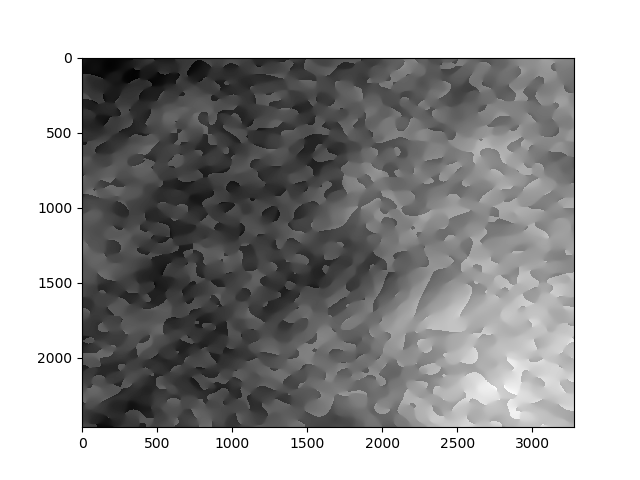

In [187]:
plt.figure()
plt.imshow(unwrapped_phase, cmap='gray')
plt.show()

In [203]:
rect_center_r=150

In [29]:
capture_image()
calculate_fourier()
calculate_phaseangle()

[[  0   0   0 ...   0   0   0]
 [208   0 198 ...   0  28   0]
 [  0   0   0 ...   0   0   0]
 ...
 [186   0 158 ...   0  43   0]
 [  0   0   0 ...   0   0   0]
 [173   0 185 ...   0  43   0]] (1944, 2592)


<IPython.core.display.Javascript object>


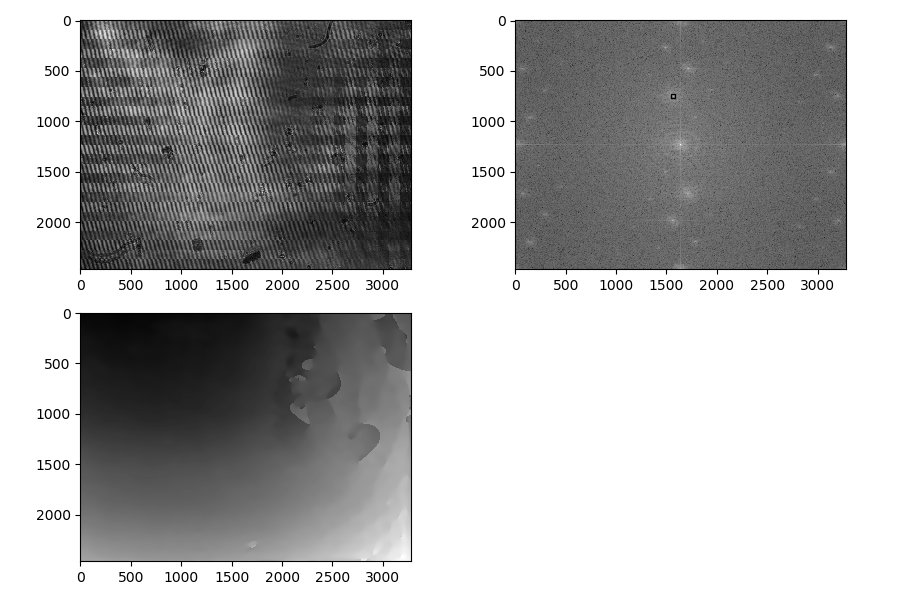

(4928, 6560) 2464 3280
(2464, 3280)


Widget Javascript not detected.  It may not be installed or enabled properly.


In [204]:
fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(221)
ax1.imshow(image, cmap='gray')



ax2 = fig1.add_subplot(222)
ax2.imshow(magnitude_spectrum, cmap='gray')

ax3 = fig1.add_subplot(223)
ax3.imshow(phaseangle, cmap='gray')

satellite_patch = matplotlib.patches.Rectangle((rect_center_x - rect_center_radius, rect_center_y - rect_center_radius),
                                              rect_center_radius*2, rect_center_radius*2)
satellite_patch.fill = False

ax2.add_patch(satellite_patch)

fig1.tight_layout()
fig1.show()


def capture_button_clicked(arg):
    capture_image()
    calculate_fourier()
    calculate_phaseangle()
    reconstruct_phase()
    ax1.imshow(image, cmap='gray')
    ax2.imshow(magnitude_spectrum, cmap='gray')
    ax3.imshow(unwrapped_phase, cmap='gray')
    fig1.show()
    
def rect_changed(change):
    global rect_center_x, rect_center_y, rect_center_radius, satellite_patch
    if(change['owner'] == rect_x_slider):
        rect_center_x = change['new']
    elif(change['owner'] == rect_y_slider):
        rect_center_y = change['new']
    elif(change['owner'] == rect_r_slider):
        rect_center_radius = change['new']
    update_rect()

def update_rect():
    satellite_patch.set_xy((rect_center_x-rect_center_radius, rect_center_y-rect_center_radius))
    satellite_patch.set_width(rect_center_radius*2)
    satellite_patch.set_height(rect_center_radius*2)
    calculate_phaseangle()
    reconstruct_phase()
    ax3.imshow(unwrapped_phase, cmap='gray')
    fig1.tight_layout()
    fig1.canvas.draw()

    

cap_btn = widgets.Button(
    description='Capture',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Retrieves a new image',
    icon='check',
    on_click=capture_button_clicked
)
cap_btn.on_click(capture_button_clicked)
rect_x_slider = widgets.IntSlider(
    value = width // 2,
    min = 0,
    max = width,
    step = 1,
    description='Satellite X Position',
    orientation='horizontal',
    continuous_update=False
)
rect_y_slider = widgets.IntSlider(
    value = height // 2,
    min = 0,
    max = height,
    step = 1,
    description='Satellite Y Position',
    orientation='horizontal',
    continuous_update=False
)
rect_r_slider = widgets.IntSlider(
    value = 35,
    min = 0,
    max = 200,
    step = 1,
    description='Satellite Radius',
    orientation='horizontal',
    continuous_update=False
)
slider_vbox = widgets.VBox([rect_x_slider, rect_y_slider, rect_r_slider, cap_btn])
display(slider_vbox)
rect_x_slider.observe(rect_changed, names='value')
rect_y_slider.observe(rect_changed, names='value')
rect_r_slider.observe(rect_changed, names='value')